In [1]:
import tensorflow as tf
import keras
import numpy as np
import time
from keras.applications.mobilenet import MobileNet
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [2]:
NAME = "Farzad-keras_face_recognition_MobileNet-Small-12-layertrainable_{}".format(int(time.time()))
config = tf.ConfigProto( device_count = { 'GPU': 1 , 'CPU': 6} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)


In [3]:
#custom parameters
nb_class = 225
hidden_dim = 256

model = MobileNet(include_top=False, input_shape=(224, 224, 3), classes=nb_class)
# model.summary()

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
last_layer = model.get_layer('conv_pw_13_relu').output
x = Flatten(name='flatten')(last_layer)
x = Dense(hidden_dim, activation='relu', name='fc6')(x)
x = Dense(hidden_dim, activation='relu', name='fc7')(x)
out = Dense(nb_class, activation='softmax', name='fc8')(x)
custom_model = Model(model.input, out)
# custom_model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [5]:
for layer in custom_model.layers[:-12]:
    layer.trainable = False
# custom_model.summary()

In [8]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 64

# All images will be rescaled by 1./255 as we need to normalize them before feeding to the network
train_datagen = ImageDataGenerator(rescale=1/255,rotation_range=10,width_shift_range=0.1, \
                                  zoom_range=0.1, horizontal_flip=True,channel_shift_range=10.0,\
                                 )
validation_datagen = ImageDataGenerator(rescale=1/255)

# We can also use train_datagen.flow(X, label_X) but with flow_from_directory, the classname will be each directory
train_generator = train_datagen.flow_from_directory(
        './DataComplete/train/',  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical',
        shuffle=True)

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        './DataComplete/validation',  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical',
        shuffle=True)


Found 30131 images belonging to 225 classes.
Found 5184 images belonging to 225 classes.


In [9]:
custom_model.compile(optimizer=keras.optimizers.Adam(lr=0.0002), loss='categorical_crossentropy',metrics=['accuracy'])


filepath= NAME + "-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1,save_weights_only=False, save_best_only=True, mode='max')
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))
callbacks_list = [checkpoint, tensorboard]


In [10]:
# sess.run(tf.global_variables_initializer())
custom_model.fit_generator(train_generator,
      steps_per_epoch=np.ceil(train_generator.samples//batch_size),  
      epochs=20,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=np.ceil(validation_generator.samples//batch_size),
      callbacks =callbacks_list
    )

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
471/470 [==============================] - 269s 570ms/step - loss: 4.1643 - acc: 0.1664 - val_loss: 3.3180 - val_acc: 0.2843
Epoch 2/20
471/470 [==============================] - 263s 558ms/step - loss: 2.6021 - acc: 0.3964 - val_loss: 2.4631 - val_acc: 0.4421
Epoch 3/20
471/470 [==============================] - 264s 561ms/step - loss: 2.0077 - acc: 0.5161 - val_loss: 2.1109 - val_acc: 0.5150
Epoch 4/20
471/470 [==============================] - 262s 556ms/step - loss: 1.6623 - acc: 0.5850 - val_loss: 2.1202 - val_acc: 0.5104
Epoch 5/20
471/470 [==============================] - 261s 554ms/step - loss: 1.4450 - acc: 0.6340 - val_loss: 1.8621 - val_acc: 0.5747
Epoch 6/20
471/470 [==============================] - 264s 561ms/step - loss: 1.2885 - acc: 0.6668 - val_loss: 1.7364 - val_acc: 0.6040
Epoch 7/20
471/470 [==============================] - 263s 557ms/step - loss: 1.1625 - acc: 0.6966 - val_loss: 1.7329 - val_acc: 0.6169


## Experiments with face embeddings

Although the loss function for training the model was not triplet loss (as mentioned in FaceNet article) in this part we can check if we can cluster face embeddings (outputs of semi-final layer) with KNN.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = custom_model.predict_generator(validation_generator, validation_generator.samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
y_pred

In [21]:
from keras.preprocessing import image
from keras.applications import imagenet_utils

def prepare_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [26]:
from keras import backend as K

# with a Sequential model
layer_name = 'fc7'
intermediate_layer_model = Model(inputs=custom_model.input,
                                 outputs=custom_model.get_layer(layer_name).output)
def get_embedding(x, itermed_model):
    return intermediate_layer_model.predict(x)

get_embedding(prepare_image('./Data/validation/Scott_Morrison/1.jpg'), intermediate_layer_model).shape

(1, 256)

In [27]:
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
d = {}
count = 0
for person in os.listdir('./DataComplete/train/'):

    images_name = os.listdir('./DataComplete/train/' + person)
    d[person] = np.array([prepare_image('./DataComplete/train/' + person + '/' + image_name) for image_name in images_name])

In [48]:
d_valid = {}
count = 0
for person in os.listdir('./DataComplete/validation/'):

    images_name = os.listdir('./DataComplete/validation/' + person)
    d_valid[person] = np.array([prepare_image('./DataComplete/validation/' + person + '/' + image_name) for image_name in images_name])

In [46]:
embeddings = {}
np.squeeze(np.array([get_embedding(x, intermediate_layer_model) for x in d['Milton_Dick']]))

225

In [50]:
milton = np.squeeze(np.array([get_embedding(x, intermediate_layer_model) for x in d['Milton_Dick']]))
scott = np.squeeze(np.array([get_embedding(x, intermediate_layer_model) for x in d['Scott_Morrison']]))
matt = np.squeeze(np.array([get_embedding(x, intermediate_layer_model) for x in d['Matt_Thistlethwaite']]))
tanya = np.squeeze(np.array([get_embedding(x, intermediate_layer_model) for x in d['Tanya_Plibersek']]))
mark = np.squeeze(np.array([get_embedding(x, intermediate_layer_model) for x in d['Mark_Coulton']]))

In [51]:
milton_val = np.squeeze(np.array([get_embedding(x, intermediate_layer_model) for x in d_valid['Milton_Dick']]))
scott_val = np.squeeze(np.array([get_embedding(x, intermediate_layer_model) for x in d_valid['Scott_Morrison']]))
matt_val = np.squeeze(np.array([get_embedding(x, intermediate_layer_model) for x in d_valid['Matt_Thistlethwaite']]))
tanya_val = np.squeeze(np.array([get_embedding(x, intermediate_layer_model) for x in d_valid['Tanya_Plibersek']]))
mark_val = np.squeeze(np.array([get_embedding(x, intermediate_layer_model) for x in d_valid['Mark_Coulton']]))

In [53]:
# clare = np.squeeze(np.array([get_embedding(x, intermediate_layer_model) for x in d['Mark_Coulton']]))

data = np.vstack((milton, scott, matt, tanya, mark))

In [99]:
vals = [milton_val, scott_val, matt_val, tanya_val, mark_val]

In [105]:
y = [[0]* len(milton), [1]*len(scott), [2] * len(matt), [3] * len(tanya), [4] * len(mark)]
y = [elem for sublist in y for elem in sublist]

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=40)
neigh.fit(data, y)  

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=40, p=2,
           weights='uniform')

In [32]:
from sklearn.manifold import TSNE
import time

fashion_tsne = TSNE(random_state=1, n_components=2).fit_transform(data)

In [88]:
import seaborn as sns
import matplotlib.patheffects as PathEffects

def f_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 576x576 with 1 Axes>,
 [Text(14.088811, 36.32291, '0'),
  Text(-5.0201516, -43.17924, '1'),
  Text(13.248639, 3.066583, '2'),
  Text(-42.89201, 9.395007, '3'),
  Text(19.06143, -22.536152, '4')])

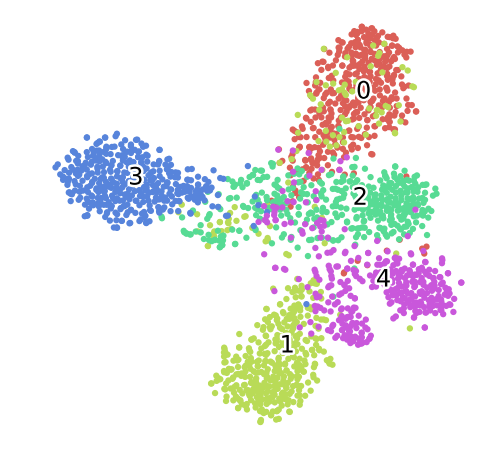

In [89]:
f_scatter(fashion_tsne,np.array([0] * len(scott) + [1] * len(milton) + [2] * len(matt) + \
                               [3]* len(tanya) + [4] * len(mark)))